### Compute the stationary distribution of the model

Proof of concept of the stationary distribution of the model. Does not make use of CompEcon code, or rely on linear basis matrices. 

Works, but still more to do. 

- Need to generalize the code to take models with any number of Markov states and state variables.

In [1]:
# Setup
import numpy as np
import scipy.sparse as spa
import matplotlib.pyplot as plt
from dolo.algos.dtmscc.time_iteration import time_iteration
from dolo import yaml_import
from dolo import pcat
from dolo.algos.dtmscc.distributions import stat_dist

In [2]:
filename = 'incomplete_markets_dtmscc.yaml'
model = yaml_import(filename)

In [3]:
# Use time iteration to create decision rule and 
drc = time_iteration(model, with_complementarities=True, verbose=False, output_type='controls') 
mdr = time_iteration(model, with_complementarities=True, verbose=False, output_type='dr') 

In [4]:
L, QT, kgridf = stat_dist(model, mdr, Nkf=1000, verbose=False)

### Construct the transition matrices

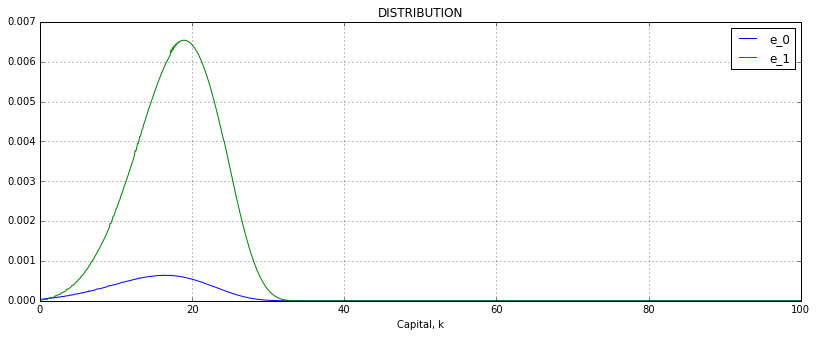

In [5]:
%matplotlib inline

plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(kgridf, L[:,0],label='e_0')
plt.plot(kgridf, L[:,1],label='e_1')
plt.xlabel('Capital, k')
plt.title('DISTRIBUTION')
plt.legend()
plt.grid()

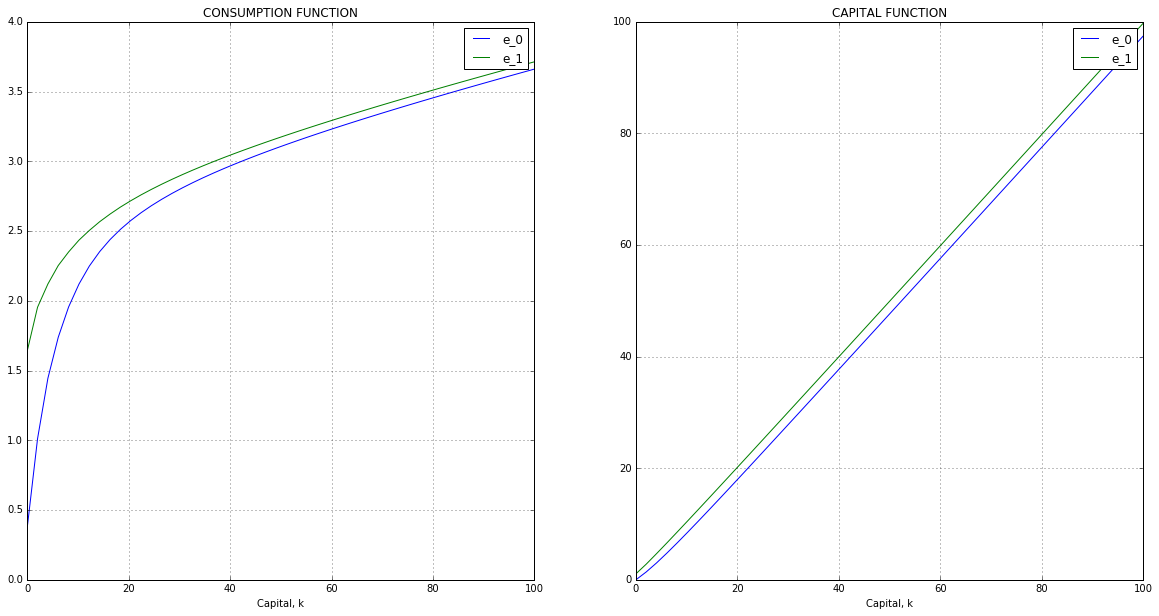

In [111]:
# Plot controls

%matplotlib inline
kgrid = mdr.grid

plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.plot(kgrid, drc[0,:],label='e_0')
plt.plot(kgrid, drc[1,:],label='e_1')
plt.xlabel('Capital, k')
plt.title('CONSUMPTION FUNCTION')
plt.legend()
plt.grid()

plt.subplot(122)
plt.plot(kgrid, kprime0,label='e_0')
plt.plot(kgrid, kprime1,label='e_1')
plt.xlabel('Capital, k')
plt.title('CAPITAL FUNCTION')
plt.legend()
plt.grid()

#### Create a function that takes transition back to control

For models in which we can use the $s_{t+1}$ trick, need to create a function that takes this transition rule back to the control. 